In [5]:
# Jason's implementation of directional algo
from algorithim import Params, Algorithm, Capon
from scipy.signal import find_peaks

import os
os.environ['DRJIT_LIBLLVM_PATH'] = '/usr/lib/x86_64-linux-gnu/libLLVM.so:'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os # Configure which GPU

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
    print(f"Using GPU {gpu_num}")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
print(f"Found {len(gpus)} GPUs")
if gpus:
    print(f"Found GPU: {gpus[0].name}")
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 1 GPUs
Found GPU: /physical_device:GPU:0
Physical devices cannot be modified after being initialized


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, AntennaArray, Antenna

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid

def calculate_heading_rad(start, end):
    # Calculate the difference vector
    diff = np.array(end) - np.array(start)
    
    # Calculate the heading angle in radians
    heading = np.arctan2(diff[1], diff[0])
    
    return heading

def get_rss_from_csi(csi):
  # Compute CSI power (power per subcarrier)
  csi_power = tf.abs(csi)**2

  # Compute RSS per receiver-transmitter pair (sum over subcarriers)
  rss_per_rx_tx = tf.reduce_sum(csi_power, axis=-1)  # Sum over subcarriers

  # Convert RSS from linear scale (e.g., Watts) to dBm
  rss_per_rx_tx_dBm = 10 * tf.math.log(rss_per_rx_tx / 1e-3) / tf.math.log(10.0)

  return rss_per_rx_tx_dBm

def dbm_to_watts(dbm):
    return 10. ** ((dbm-30)/10)

def watts_to_dbm(watts):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return 10 * np.log10(watts + epsilon) + 30

# # Multiple Antennas like ASUS Router
def get_antenna_positions(spacing):
    return np.array([[0.0, spacing / 2 + spacing , 0.0],
                     [0.0, spacing / 2, 0.0],
                     [0.0, -spacing / 2, 0.0],
                     [0.0, -spacing / 2 - spacing, 0.0]])

def flip_trajectory(data):
    # Vector from origin to the first and last points of each trajectory
    first_points = data[:, 0, :]  # Shape (1000, 3)
    last_points = data[:, -1, :]  # Shape (1000, 3)

    # Compute the dot product of the first and last points with respect to the origin
    dot_products = np.sum(first_points * last_points, axis=1)

    # Identify trajectories heading away from the origin (dot product > 0)
    away_from_origin = dot_products < 0

    # Flip the trajectories that are not heading away from the origin
    data[~away_from_origin] = data[~away_from_origin, ::-1, :]

    return data

In [7]:
# List for dataset
angles = []
angle_profile_values = []
rssi = []
rssi_normalized = []


In [8]:
SCENE_NAME = "canyon"
IMAGE_FOLDER = f"images/{SCENE_NAME}"

# os.environ['DRJIT_LIBLLVM_PATH'] = '/usr/lib/x86_64-linux-gnu/libLLVM.so:'
# os.environ['LD_LIBRARY_PATH'] = '/usr/lib/llvm-14/lib'
# Load integrated scene
scene = load_scene(f"models/{SCENE_NAME}.xml") # Try also sionna.rt.scene.etoile
# scene = load_scene(sionna.rt.scene.simple_wedge)

my_cam = Camera("my_cam", position=[10,0,30], look_at=[10,0,0])
scene.add(my_cam)

In [9]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# To visualize the antenna array
# scene.tx_array.show()

# # Configure antenna array for all receivers
# scene.rx_array = PlanarArray(num_rows=1,
#                              num_cols=1,
#                              vertical_spacing=0.5,
#                              horizontal_spacing=0.5,
#                              pattern="iso",
#                              polarization="V")

antenna_positions = get_antenna_positions(0.03)

antenna_array_angle = -175 # Default

RelativeAntennas = AntennaArray(antenna=Antenna("dipole", "V"), 
                            positions=tf.Variable(antenna_positions.tolist()))

# scene.tx_array = RelativeAntennas 
scene.rx_array = RelativeAntennas

# Create transmitter
tx = Transmitter(name="tx",
                 position=[0., -10., 0.],
                 orientation=[np.radians(0),0,0])

# Add transmitter instance to scene
scene.add(tx)

trajectories = np.load('trajectories_test.npy')
trajectories = flip_trajectory(trajectories)
trajectory_index = 0
num_steps = trajectories.shape[1]
trajectory_steps =  np.arange(num_steps - 1)# [10, 12, 14, 16, 18]

start_color = np.array([1, 0, 0])  # Red
end_color = np.array([0, 0, 1]) 
colors = [start_color + (end_color - start_color) * i / (num_steps - 1) for i in range(num_steps)]

# Calculate headings for the trajectory
calculated_headings = []
for i in trajectory_steps: #range(0, len(trajectories[0]) - 1):
    heading = calculate_heading_rad(trajectories[trajectory_index,i,:2], trajectories[trajectory_index,i + 1,:2])
    calculated_headings.append(heading)

rxs = []
for i, position in enumerate(trajectories[trajectory_index, np.arange(num_steps),:]):
    if i == (trajectories[0].shape[0] - 1):
        heading = calculated_headings[-1]
    else:
        heading = calculated_headings[i]
    rxs.append(Receiver(name=f"rx{i}",
              position=position,
              orientation=[heading,0,0]))    
    scene.add(rxs[i])

antenna_array_angle = np.radians(180) # heading

In [10]:
scene.frequency = 2.14e9 #5.745 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = False # If set to False, ray tracing will be done per antenna element (slower for large arrays)
"When the property scene.synthetic_array is set to False, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array. Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed"

'When the property scene.synthetic_array is set to False, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array. Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed'

csi.shape (1, 20, 4, 1, 1, 1, 52)


<Figure size 640x480 with 0 Axes>

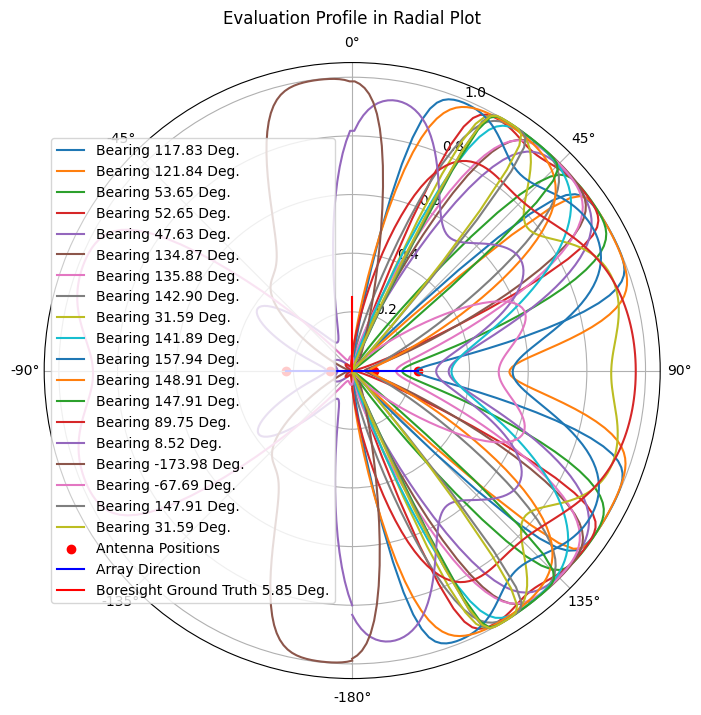

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [ ]:
# Compute propagation paths
# sionna.rt.Scene.compute_paths(self, max_depth=3, method='fibonacci', num_samples=1000000, los=True, reflection=True, 
#                               diffraction=False, scattering=False, ris=True, scat_keep_prob=0.001, edge_diffraction=False, 
#                               check_scene=True, scat_random_phases=True, testing=False)
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6,  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths
                            los=True,  # Include Line-of-Sight paths
                            reflection=True,  # Include reflection paths
                            diffraction=True,  # Include diffraction paths
                            scattering=True,  # Include scattering paths
                            )

paths.normalize_delays = False

# Determine subcarrier frequencies
rg = ResourceGrid(num_ofdm_symbols=1,
                fft_size=52,
                dc_null = True,
                cyclic_prefix_length=20,
                #   pilot_pattern = "kronecker",
                #   pilot_ofdm_symbol_indices = [2, 8],
                subcarrier_spacing=5e6) #30e3)

frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# get rss
a, tau = paths.cir()

csi = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)  # Non-normalized includes path-loss
print(f"csi.shape {csi.shape}")
csi_reshaped = []
for i in range(len(rxs)):
    csi_reshaped.append(np.array(csi[:,i,:,:,:,:,:]).reshape(4, 52))

# # Create a figure with 4 subplots
# fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# # Plot each array in a separate subplot
# for j in range(len(rxs)):
#     for i in range(4):
#         axs[i].plot(csi_reshaped[j][i])
#         axs[i].set_title(f'Array {i+1}')
#         axs[i].set_xlabel('Frequency Index')
#         axs[i].set_ylabel('Value')


# Adjust layout
plt.tight_layout()
plt.show()

#Output: h_f ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size], tf.complex) – Channel frequency responses at frequencies
block_rss = get_rss_from_csi(csi).numpy()[0, :, 0, 0, 0, 0]
block_rss[np.isneginf(block_rss)] = -90
rssi.append(block_rss[:-1])
# Define range
min_rss = -90
max_rss = 0

# Normalize values to 0-1
normalized = (block_rss - min_rss) / (max_rss - min_rss)
rssi_normalized.append(normalized[:-1])

# Define three colors
color_black = np.array([0, 0, 0])
color_red = np.array([1, 0, 0])
color_blue = np.array([0, 0, 1])
colors = []
for value in normalized:
    if value <= 0.5:
        # Scale between black and gray
        color = color_black + (color_red - color_black) * (value / 0.5)
    else:
        # Scale between gray and white
        color = color_red + (color_blue - color_red) * ((value - 0.5) / 0.5)
    colors.append(color)

# Map normalized values to colors
# 0-1 range is split into 3 intervals: [0, 1/3), [1/3, 2/3), [2/3, 1]
# color_indices = np.digitize(normalized, bins=[1/3, 2/3], right=False)
# mapped_colors = [colors[idx] for idx in color_indices]

for i, rx in enumerate(rxs):
    rx.color = colors[i]


# Implementing Capon Algorithim
params = Params(antenna_positions[:, :2])

# Create a radial plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
angle_tmp = []
angle_profile_values_tmp = []
for i in range(0, len(rxs) - 1):
    
    csi_tmp = tf.reshape(csi[:,i,:,:,:,:,:], [4, 52]) #  tf.reshape(csi[:,i,:,:,:,:,:], [1, -1])

    AOA, theta_samples, profile_norm = Capon(params, 155, 80, csi_tmp).evaluate()

    # This for when going towards transmitter
    profile_norm = np.roll(profile_norm, 180)
    # Capture three top peaks from bottom of profile (90-270 degrees)
    evaluation = np.array([profile_norm[90:270]])
    evaluation = evaluation.flatten() 
    peaks, _ = find_peaks(evaluation)
    peak_values = evaluation[peaks]

    angle_profile_values_tmp.append(peak_values)
    angle_tmp.append(theta_samples[90:270][peaks])
    
    AOA = np.array([AOA])

    # Plot the evaluation profile
    ax.plot(theta_samples, profile_norm, label=f'Bearing {-np.degrees(AOA[0]):.2f} Deg.')

angles.append(angle_tmp)

angle_profile_values.append(angle_profile_values_tmp)

# Draw antenna array
# Rotation angle in radians for AoA algorithm
theta = 0 #antenna_array_angle # + 180)

# Rotation matrix for the z-plane
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

# Rotate antenna positions
rotated_positions = np.dot(antenna_positions, R_z.T)
dx = rotated_positions[:, :1]
dy = rotated_positions[:, 1:2]
angles_antenna = np.arctan2(dy, dx)  # Angles in radians
magnitudes = 5*np.sqrt(dx**2 + dy**2)  # Distances (optional for scaling)

# Boresight is perpendicular to the array_vector
array_vector = np.array([dx[-1] - dx[0], dy[-1] - dy[0]])
# Rotate 90 degrees (swap x and y, and negate one)
boresight_vector = np.array([-array_vector[1], array_vector[0]])
boresight_angle = np.arctan2(boresight_vector[1], boresight_vector[0])

# Plotting on a polar plot
ax.scatter(angles_antenna, magnitudes, c='r', label="Antenna Positions")  # Points
ax.plot(angles_antenna, magnitudes, 'b-', label="Array Direction") 
ax.plot([boresight_angle, boresight_angle], [0, .25], 'r-', label=f"Boresight Ground Truth {np.degrees(heading):.2f} Deg.")

# Add labels and legend
ax.set_title("Evaluation Profile in Radial Plot", va='bottom')
ax.set_theta_zero_location("N")  # Zero angle at the top (North)
ax.set_theta_direction(-1)  # Clockwise angle direction
ax.set_thetamin(-180) # only show top half
ax.set_thetamax(180)

# Show plot
plt.legend()
plt.show()

csi_reading = watts_to_dbm(tf.abs(csi.numpy().flatten()))

# scene.preview(show_orientations=True) # Use the mouse to focus on the visualized paths
scene.preview(paths, show_devices=True, show_paths=False, show_orientations=True) # Use the mouse to focus on the visualized paths

In [ ]:
print(angles)
print(angle_profile_values)
print(rssi)
# angles = []
# angle_profile_values = []
# rssi = []
# rssi_normalized = []


[[array([-0.35878913,  1.00635976]), array([0.65632159]), array([0.67382349]), array([-0.0962605 ,  0.00875095,  1.42640558]), array([-0.34128722,  1.28639031]), array([-0.21877386,  1.28639031]), array([-0.21877386,  0.8838464 ]), array([-0.23627577]), array([-0.23627577,  1.25138649]), array([-0.23627577,  0.65632159]), array([-0.25377768,  0.76133304]), array([-0.41129486,  0.58631395]), array([-0.25377768,  0.79633686]), array([-0.30628341,  0.90134831]), array([-0.32378532,  1.30389222]), array([-1.4789113 , -0.32378532,  1.23388458]), array([-0.30628341,  0.90134831]), array([-0.21877386]), array([0.83134067])]]
[[array([0.91671915, 0.63211251]), array([0.99997614]), array([0.99985884]), array([0.74834623, 0.68156133, 0.99358113]), array([0.91679735, 0.98702927]), array([0.99736518, 0.85288632]), array([0.99881677, 0.06870347]), array([0.99935552]), array([0.9991151 , 0.05506443]), array([0.99793394, 0.62535238]), array([0.9877084 , 0.87357579]), array([0.98194436, 0.68638103]), 